# 5MA Sujet de projet

# Transfert d'organe sous incertitude sur la compatibilité

Avant de commencer, il faut placer le curseur du répertoire courant à la racine du projet. Cela sera nécessaire pour la suite.

In [1]:
using 
Random, 
MetaGraphs, 
SimpleWeightedGraphs, 
Graphs, 
JuMP, 
DelimitedFiles, 
Distributions,  
GraphPlot, 
HiGHS, 
DataFrames, 
Plots, 
BenchmarkTools,
Statistics

while (last(split(pwd(), Base.Filesystem.path_separator)) != "KidneyExchangeProgram")
    cd("..")
end
println(pwd())

c:\Users\loicf\Documents\INSA\GM\5GM\OptimIncert\KidneyExchangeProgram


Nous importons ici les différents fichiers qui seront nécessaires au bon fonctionnement de ce projet. Pour que l'import de ces fichiers se fasse sans erreur, il est nécessaire que le curseur du répertoire courant soit placé à la racine de ce répertoire.

In [2]:
# include files for the data reading and data extraction
include(join(["utils", "graph_extraction.jl"], Base.Filesystem.path_separator))
include(join(["utils", "data_reading.jl"], Base.Filesystem.path_separator))

# include files for the modeling and solving part

## stochastic optimization
include(join(["src", "stochastic_framework", "master_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "recourse_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "unroll_problem.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "solver.jl"], Base.Filesystem.path_separator))
include(join(["src", "stochastic_framework", "solution_evaluation.jl"], Base.Filesystem.path_separator))

## deterministic optimization
include(join(["src", "dtm_framework", "complete_recourse.jl"], Base.Filesystem.path_separator))

# for the random simulations
include(join(["utils", "monte_carlo.jl"], Base.Filesystem.path_separator))

# for displaying the solution
include(join(["utils", "visualization.jl"], Base.Filesystem.path_separator))
include(join(["utils", "sum_up.jl"], Base.Filesystem.path_separator))
include(join(["utils", "graph_modification.jl"], Base.Filesystem.path_separator))
    
# for solution extraction
include(join(["utils", "solution_extraction.jl"], Base.Filesystem.path_separator))

# for sorting cycle
include(join(["utils", "cluster_utils.jl"], Base.Filesystem.path_separator))
;

## Introduction

Malgré l'augmentation croissante du nombre de transplantations d'organes effectuées chaque année (environ 6000 en 2017 dont 3782 transplantations de reins), la demande reste en perpétuelle augmentation. Ainsi 6000 organes, dont 3782 reins, ont été transplantés en 2017, mais il y avait encore 24000 personnes en attente d'un organe la même année. Les organes transplantés peuvent provenir d'un donneur décédé ou, dans le cas des reins et du foie, d'un donneur vivant consentant, le plus souvent membre de la famille du patient. Hélas, même si un proche accepte de prendre ce risque pour sa santé, il ne sera pas forcément compatible avec le patient. Pour cette raison, les pratiques médicales les législations évoluent dans de nombreux pays afin de permettre la mise en place d'un programme d'échange de dons d'organes.

L'exemple le plus simple d'échange de don d'organes est celui où deux patients $P_1$ et $P_2$ sont accompagnés de donneurs $D_1$ et $D_2$. Les patients sont supposés incompatibles avec les donneurs qui les accompagnent, mais on suppose que $D_1$ est compatible avec $P_2$ et $D_2$ avec $P_1$. Il est alors possible de transplanter un organe de $D_1$ vers $P_2$ et de $D_2$ vers $P_1$ avec le consentement de tous et en suivant la procédure légale.

Plus généralement, un cycle d'échange d'organes associe $k$ paires de patient-donneur $(P_{i_1},D_{i_1}), \dots, P_{i_k},D_{i_k})$ de sorte que $D_{i_l}$ donne à $P_{i_{l+1}}$ pour $l=1,\dots,k-1$ et $D_{i_k}$ donne à $P_{i_1}$.
Par ailleurs, le point essentiel est que les transferts soient tous réalisés en même temps et dans le même hôpital pour éviter qu'une rétractation de dernière minute ne lèse un patient et son donneur, et que les patients et donneurs venus ensemble et leur famille puissent se soutenir émotionnellement durant l'hospitalisation. 
Pour cette raison, le nombre d'échanges prenant place au sein d'un même cycle est nécessairement limité. En pratique, l'organisation d'un cycle de trois paires est déjà une épreuve pour le personnel d'un hôpital, et le plus grand cycle ayant jamais eu lieu a a impliqué six patients et donneurs.

Dans ce projet, nous prendrons le point de vue de l'organisme national responsable de la gestion du programme d'échange d'organes. 
À chaque phase d'échange, l'objectif de cet organisme est de choisir un ensemble de cycles d'échanges entre paires compatibles afin de maximiser le nombre de patients recevant un organe. Dans certains cas, on peut aussi donner une priorité à certains patients en fonction de la gravité de leur état ou de la durée de leur attente. 
Pour cela, on pourra attribuer des poids différents à chaque patient et maximiser la somme des poids des patients recevant un organe. 

Lors d'une première phase de planification, l'organisme ne dispose que de données individuelles sur chaque donneur et chaque receveur pour déduire la compatibilité entre donneurs et patients. 
Ces données sont principalement le groupe sanguin et le complexe majeur d’histocompatibilité, aussi appelé système HLA. 
Ils en tirent un premier graphe de compatibilité orienté, $G=(V,A)$, où chaque sommet de $V$ représente une paire donneur-patient et où un arc entre deux paires $(P_k,D_k)$ et $(P_l,D_l)$ signifie que $D_k$ est __a priori__ compatible avec $P_l$.
Cependant, la compatibilité effective entre deux personnes ne peut être assurée qu'en mettant en présence des tissus des deux personnes dans ce que l'on appelle un _test croisé_. 
En général, on peut supposer que les données individuelles permettent de déterminer une probabilité de réussite du test croisé.
Mais, dans tous les cas, ces tests peuvent être lourds à réaliser pour les patients et demander des ressources importantes aupèrs des services hospitaliers, donc leur nombre sera toujours limité. 
On pourra pour cela considérer une limite fixe, une limite dépendant du nombre de paires patient-donneur ou bien supposer que les tests ne servent qu'à confirmer la compatibilité après avoir décidé les cycles d'échange entre patients a priori compatibles. 

## Description des données

Des jeux de données correspondant à des ensembles de paires patient-donneur ont été partagés dans la PrefLib (https://www.preflib.org/data/MD). Le sous-ensemble d'instances auxquels vous pourrez vous intéresser dans un premier temps accompagne ce sujet sur Moodle. Les dix premières instances (numérotées de 1 à 10) contiennent 10 paires patient-donneur, les 10 suivantes (numérotées de 31 à 40) en contiennent 32 et les 10 dernières (numérotées de 71 à 80) en contiennent 64. Chaque jeu de données est décrit par deux fichiers, l'un énumérant les données relatives à chaque paire et portant l'extension .dat, et l'autre énumérant les données relatives aux arcs et portant l'extension .wmd.
Nous vous fournissons une fonction permettant de lire les fichiers relatifs à un jeu de donnéees. 

Une fois le graphe de compatibilité donné, une instance est entièrement décrite par la connaissance de la distribution des incertitudes dans une approche par optimisation stochastique. Dans une approche par optimisation robuste, le pire cas est déjà connu pour chaque arête, il s'agit d'un échec de la transplantation. Plusieurs modèles d'incertitudes sont classiquement regardés dans la littérature, mais tous considèrent que la réussite du test croisé réalisé sur un arc $a$ suit une loi de Bernouilli de probabilité $1-f_a$ où $f_a$ est une probabilité d'échec donnée. Nous donnons ci-dessous la fonction permettant de calculer des probabilités d'échec pour tous les arcs en fonction d'un paramètre à choisir dans le tableau DISTRIBUTIONS.

## Travail à réaliser

Nous vous donnons une grande liberté sur la façon de traiter le sujet. En fonction de décisions que vous justifierez, vous pourrez traiter le problème par une approche d'optimisation stochastique, d'optimisation robuste ou de toute autre approche averse aux risques. Le travail commencera par décrire l'approche suivie puis le modèle en découlant. Un code Julia permettra ensuite d'implémenter une ou plusieurs méthodes de résolution pour le modèle. Vous pourrez tester la ou les méthodes sur des instances de la PrefLib. Vos interprétations devront rendre compte des enjeux pratiques et des enjeux algorithmiques (optimalité, temps de calcul, passage à l'échelle, etc.) de votre travail.
Le résultat de votre travail sera à rendre dans ce notebook avant le 14 janvier 2022. Chaque cellule du notebook aura préalablement été exécutée (sans erreur, évidemment), et il importera que les affichages utilisés dans vos interprétations y apparaissent. 

## Le problème du Kidney exchange 

Le problème du $\textbf{Kidney Exchange}$ est un problème qui est grandement étudié et qui a reçu une grande attention dans la communauté scientifique comme peuvent le montrer les articles [1], [2] et [3]. C'est un problème qui consiste à constituer des cycles de patients/doneurs pour réaliser des échanges de reins. C'est un problème très important pour la survie des patients qui souffrent de problèmes reins. Il n'est simple de trouver dans son entourage une personne prête à donner un de ses reins. De plus, même si une personne se porte volaire, pour qu'un échange soit réalisé, il faut que les tissus du patients et du donneur soient compatibles. Pour connaître cette compatibilité, il faut que les groupes de patients donneurs fassent des tests de compatibilité. Le problème  de Kidney exchange se propose de résoudre ce problème en créant des groupes/cycles de patients donneurs. Les cycles peuvent ainsi être constitués de plus de 2 ou plus groupes de patient/doneurs.


Derrière ce problème, se cache un problème d'optimisation discrète. Pour formuler correctement ce problème, se pose la question de la modélisation et des hypothèses à réaliser. On voudrait que le problème puisse être résolu en temps raisonnable et qu'il soit le plus réaliste possible.

Les enjeux et objectifs sont multiplies. On voudrait bien sûr transplanter le plus de receveur possible. Cependant, on voudrait aussi limiter le nombre de tests de compatibilité, car cela engendre des coûts économiques de matériels, de personnels, transports.

Une première difficulté opérationnelle vient du fait que des tailles de cycles de patients/doneurs supérieurs à 3 est évité, car la tâche est trop complexe pour le personnel médical. Comme évoqué dans l'article [1], l'aspect réglementation est juridique est très important, car c'est un problème qui touche au monde médical et à la santé de patient. Cette réglementation varie entre les pays.

Il existe plusieurs formulations pour ce problème. On peut raisonner en termes de cycle, de flot sur les arcs.

## Les données

Nous allons travailler ici avec des données sous forme de graphes. Les fonctions `read_kep_file` et `get_failure_rates` du fichier `.\utils\data_reading.jl` nous permettent de lire les fichier de données correspondant au problème de construire le graphe correspondant et ensuite de venir calculer les probabilités d'échec (du test croisé) de chaque arc. Voici un exemple d'utilisation des deux premières fonctions :

In [3]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000002.wmd","./_cache/data/MD-00001-00000002.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

Il est possible de visualiser une instance avec la fonction `plot_graph`

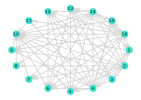

In [4]:
plot_graph(kep_graph)

La fonction `extractCycleInformation` du fichier `.\utils\graph_extraction.jl`, nous permettra de venir extraire des données du graph crée. Cette fonction est orienté sur les cycles. Elle sera beaucoup utilisée dans la suite du projet et nous permettra d'extraire de notre graphe d'échange l'ensemble des informations qui seront utiles pour la résolution de ce problème.

In [5]:
print(@doc(extractCycleInformation))

```
extractCycleInformation
```

This function allow us to extract the relevant information from the kep*graph. The relevant information here concern the cycle formulation of the kep*graph.

# Parameters

  * `g` : the kep_graph
  * `K` : the length of the Cycles
  * `mode`: the method to use to compute the calculus of the utilities
  * `utility_range` : range of the utilities

# Return

This function returns a Julia dictionnary with the following keys :

  * `Cycles_index` : a list of integer each element of the list corresponds to the index of a cycle
  * `vertic_cycles` : a dictionnary with vertices as keys and a list of cycles which involve the key as value
  * `Cycles` : the exhaustive enumeration of the cycles
  * `P` : for each cycle, the probability of failure. To get the success do 1 - ...
  * `U` : the utility of each cycle


### Un peu de pre-processing

Nous verrons par la suite que dans ce problème l'ensemble du graphe ne sera pas nécessairement utile. En effet les nœuds du graphe qui ne participent à aucun échange n'auront aucun intérêt et pourront ainsi être supprimé du graphe. La cellule suivante prend l'ensemble des instances disponibles dans le dossier `.\_cache\data` et supprime les nœuds qui ne participent à aucun cycle de longueur $3$ ou moins dans le graphe. Pour cela, nous avons créé la fonction `removeUselessNodes` qui nous permet de réaliser une telle opération. Pour illustrer l'utilité de la fonction `removeUselessNodes`, nous pouvons observer visuellement la réduction sur la taille de l'instance précédemment.

In [6]:
print(@doc(removeUselessNodes))

removetUselessNodes

Remove nodes which are not involve in cycle with given length 

# Parameters

  * `kep_graph::MetaDiGraph` : graph describing the pairs and compatibilities
  * `size_cycle` : cycle size


In [7]:
size_cycle = 3
kep_graph, list_rem_nodes = removeUselessNodes(kep_graph, size_cycle);

On conserve la liste des personnes supprimées. Cela nous permettra d'affecter les personnes correctement pour organiser les rendez-vous. Ainsi, quand on affichera notre solution, les numéros correspondront aux numéros des paires de patients avant le prétraitement.

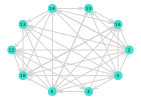

In [8]:

plot_graph(kep_graph, list_rem_nodes)

Dans le tableau suivant, nous avons fait figuré un résumé des différentes instances. Cela nous permet de gagner du temps lorsque l'on veut réaliser des expériences. D'autre part, nous avons fait figurer les nombres de nœuds et arêtes avant et après le pré-processing (`removeUselessNodes`). Cette fonction est nécessaire car plus le nombre de nœuds est important et plus l'on ajoutera des contraintes. Ainsi, les nœuds qui ne sont pas dans des cycles généreront des contraintes inutiles.  

Les deux cas qui vont nous intéresser vont être K $\in \{2, 3\}$. En effet, dans la réalité, réaliser des transplations avec plus de 3 paires est compliqué à gérer.

In [9]:
K = 2
df_plot = sum_up_instance(K)
list_name = Matrix(df_plot[:, [:name]])
print(df_plot)

error in reading
28×6 DataFrame
 Row │ name   n_edge  n_node  n_circle  n_edge_preprocess  n_node_preprocess 
     │ Int64  Int64   Int64   Int64     Int64              Int64             
─────┼───────────────────────────────────────────────────────────────────────
   1 │     1      59      16         2                  6                  4
   2 │     2      65      16         3                 17                  6
   3 │     3      50      16         2                  4                  3
   4 │     4      26      16         0                  0                  0
   5 │     5      70      16         3                  9                  4
   6 │     6      28      16         4                  8                  5
   7 │     7      48      16         3                  8                  4
   8 │     8      48      16         6                 28                  8
   9 │     9      59      16         7                 26                  8
  10 │    10      47      16         7   

In [10]:
K = 3

df_plot = sum_up_instance(K)
print(df_plot)

error in reading
28×6 DataFrame
 Row │ name   n_edge  n_node  n_circle  n_edge_preprocess  n_node_preprocess 
     │ Int64  Int64   Int64   Int64     Int64              Int64             
─────┼───────────────────────────────────────────────────────────────────────
   1 │     1      59      16         2                  6                  4
   2 │     2      65      16        10                 38                 10
   3 │     3      50      16         2                  4                  3
   4 │     4      26      16         0                  0                  0
   5 │     5      70      16        17                 39                 12
   6 │     6      28      16         4                  8                  5
   7 │     7      48      16         6                 11                  5
   8 │     8      48      16        20                 38                 11
   9 │     9      59      16        19                 40                 11
  10 │    10      47      16         7   

Nous pouvons voir que dans l'ensemble des instances, nous sommes capables de réduire le nombre de nœuds qu'il y a dans notre graphe. Nous verrons que tout ceci possède une utilité par la suite.

Maintenant que nous avons proposé quelques fonctions très utiles pour la lecture des données nous allons passer à une première résolution.

## Un problème (presque) à recours

Notre première vision de ce problème était de réfléchir uniquement sur les cycles. Nous adoptons la philosophie qui consiste à dire qu'on sélectionne des cycles et nous ne réalisons les tests croisés que parmi les cycles que nous avons sélectionnés.

On définit ainsi les données suivantes :

- $C_K$ : l'ensemble des cycles de longueurs au plus $K$
- $C_K(i)$ : l'ensemble des cycles de longueurs au plus $K$, qui contiennent le sommet $i$
- $\forall c \in C_K \quad w_c$ : désignera l'utilité du cycle $c$
- $\omega~\in~\Omega$ : définit une réalisation des incertitudes. On parlera aussi de scénario. C'est une réalisation possible de l'aléa qui pèse sur les différents arcs.
- $\forall ~c~\in C_K\quad \xi_c(\omega) \in \{0, 1\} = 1$ : si et seulement si on ne peut pas sélectionner le cycle $c$ (les tests sont mauvais) pour le scénario $\omega$

On définit les variables suivantes

- $1^{er}$ niveau : $\forall c \in C\quad x_c \in \{0, 1\} = 1$ si et seulement si, on décide de sélectionner le cycle $c$.
- recours : $\forall c \in C\quad y_c(\omega) \in \{0, 1\} = 1$ on ne peut pas sélectionner le cycle $c$ dans le scénario $\omega$

Le problème peut se modéliser ainsi de la manière suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C_K} x_cw_c +\mathbb{E}_{\omega}\left(\underset{y}{\min} \left[\sum_{c \in C_K} y_c(\omega)w_c\right]\right)\\
         s.c \quad &\sum_{c\in C_K(i)}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         % les contraintes stochastiques
         & y_c(\omega) = \xi_c(\omega)~x_c\quad \forall c \in C_K \quad \forall \omega \in \Omega\\ 
         & x_c \in \{0,1\} \quad \forall c \in C_K\\
         & y_c(\omega) \in \{0,1\} \quad \forall c \in C_K\quad \forall \omega \in \Omega
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons ainsi reformuler ce problème de la façon suivante :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & - \sum_{c \in C_K} x_cw_c +\mathbb{E}_{\omega}\left( \left[\sum_{c \in C_K} \xi_c(\omega)x_cw_c\right]\right)\\
         s.c \quad &\sum_{c\in C_K(i)}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C_K\\
	\end{aligned}\right.
\end{equation}
$$

Nous obtenons finalement :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\min} \quad & \sum_{c \in C_K} x_cw_c(\mathbb{E}_{\omega} \left[ \xi_c(\omega)\right] - 1)\\
         s.c \quad &\sum_{c\in C_K(i)}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C_K\\
	\end{aligned}\right.
\end{equation}
$$

Avec $\mathbb{E}_{\omega}[\xi_c(\omega)] = \mathbb{P}\{\xi_c(\omega) = 1\}$ d'où $\mathbb{E}_{\omega}[\xi_c(\omega)] - 1 = -\mathbb{P}\{\xi_c(\omega) = 0\}$


Ainsi nous avons :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C_K} x_cw_c(\mathbb{P}\{\xi_c(\omega) = 0\})\\
         s.c \quad &\sum_{c\in C_K(i)}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C_K\\
	\end{aligned}\right.
\end{equation}
$$


Ainsi nous notons $\tilde{w}_c = w_c \times \mathbb{P}\{\xi_c(\omega) = 0\}$, la nouvelle utilité d'un cycle qui sera en fait une combinaison entre l'utilité réelle du cyle $w_c$ et la probabilité que ce dernier se réalise. Nous pouvons ici que un cycle avec $w_c$ grand mais une probabilité de succés très faible aura peu de chance d'être choisi. En effet, pourquoi choisir ce cycle si on sait qu'il n'a aucune chance (ou presque) de se réaliser.

Nous avons finalement le problème suivant :

$$
\begin{equation}
	(\mathbb{CRP}) := \left\{\begin{aligned}
        \underset{x}{\max} \quad & \sum_{c \in C_K} x_c\hat{w}_c\\
         s.c \quad &\sum_{c\in C_K(i)}x_c\leq 1~\forall i \in V\\ % contrainte déterministe
         & x_c \in \{0,1\} \quad \forall c \in C_K\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons voir ainsi que ce problème $\mathbb{CRP}$ est donc un problème totalement déterministe. Nous proposons la méthode `completRecourseProblem` dans le fichier `dtm_framework/complete_recourse.jl`. Cette dernière fonction possède la signature suivante :

In [11]:
print(@doc(completRecourseProblem))

```
completRecourseProblem
```

This is the deterministic version of the problem with the complete recourse.

# Parameters

  * `C` : index of the cycles
  * `vertic_cycles` : a dictionnary, at the key i of this list, give the a list of the index of the cycles which involve the node i
  * `U` : the utilities of each cycle in the graph.
  * `S_P` : probability of sucess of each cycle

# Return

This function will return a julia dictionnary with the following keys :

  * `model` : the model ready to be optimized


Nous donnons ici un premier exemple simple d'une résolution de ce problème.

In [12]:
# the data
kep_graph = read_kep_file("./_cache/data/MD-00001-00000080.wmd","./_cache/data/MD-00001-00000080.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");
data = extractCycleInformation(kep_graph, 3, "sum");

# the model
res = completRecourseProblem(data["Cycles_index"], data["vertic_cycles"], data["U"], 1 .-data["P"]);
model = res["model"]

temp = @elapsed optimize!(model)

solution = value.(model[:x])
;

Il peut être intéressant de regarder sur ce genre de problème les temps de calcul que nous avons pour la résolution du problème.

Infeasible Problem
error in reading
error in reading
error in reading


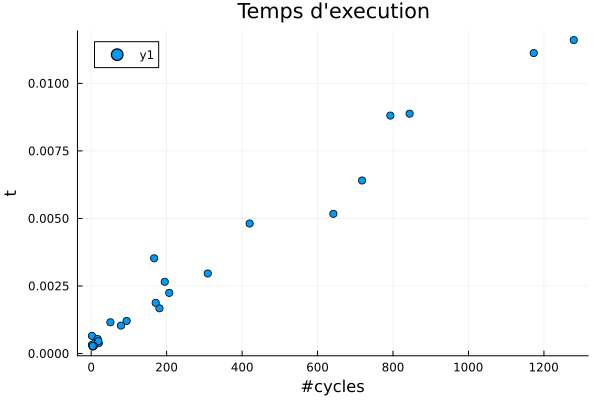

In [13]:
times = []
nb_cycles = []

j = 1
list_dir = readdir(join(["_cache", "data"], Base.Filesystem.path_separator));

for i in 1:1:(length(list_dir)/2)
    try
        kep_graph = read_kep_file("./_cache/data/"*list_dir[j+1],"./_cache/data/"*list_dir[j]);
        failure_rates = get_failure_rates(kep_graph, "Constant");
        data = extractCycleInformation(kep_graph, 3, "sum");

        append!(nb_cycles, length(data["Cycles_index"]))

        # the model
        res = completRecourseProblem(data["Cycles_index"], data["vertic_cycles"], data["U"], 1 .-data["P"]);
        model = res["model"]

        t = @elapsed optimize!(model)
        append!(times, t)
        j = j+2
    catch
        println("error in reading")
        j = j+1
    end
end;

p1 = Plots.scatter(nb_cycles, times, title="Temps d'execution")
Plots.plot(p1)
xlabel!("#cycles")
ylabel!("t")

Sans surprise, nous observons une évolution croissante du temps de calcul en fonction du nombre de cycles dans notre graphe. En fait ce problème est très connu pour devenir très difficile quand le nombre de cycles augmente. Pour pallier ceci de nombreuses études se portent sur les techniques de génération de colonnes.

Cette première méthode nous donne un bon aperçu du problème, mais ne prend pas en compte l'aspect stochastique du problème (nous avons simplement modifié l'utilité de chaque cycle).
La section suivant va nous permettre d'introduire la méthode des *clusters* et d'utiliser le *framework* de l'optimisation stochastique.

## La méthode des *clusters*

Les différents hôpitaux nous ont contactés et nous ont expliqués que ce n'était pas à nous de dicter les tests à faire entre les différents patients. Ceci relève du domaine médical et des infrastructure présentes dans chaque hôpital. Il est attendu de nous de regrouper les pairs donneurs receveur sous la forme de groupes pertinents. Les groupes formés alors seront pris en charge par un hôpital et au sein d'un groupe de personnes toutes les différentes batteries de tests vont avoir lieu et permettront de déterminer les échanges à réaliser. Pour des raisons logistiques, les hôpitaux souhaitent aussi ne prendre en charge que des groupes de tailles raisonnables. On notera dans la suite par la constante, $U$ la taille maximale des groupes autorisés. En effet sans une telle contrainte, nous pourrions mettre tous les patients dans le même groupe, réaliser tous les tests possibles et ensuite réaliser les échanges (Impossible !).

Notre objectif est alors le suivant, former des groupes (*cluster*) de personnes qui seront ensuite pris en charge par les hôpitaux. Les clusters formés comme indiqués doivent être pertinents. Ils doivent permettre en moyenne de maximiser l'utilité des échanges que l'on génère.

Nous pouvons modéliser tout ceci de manière plus formelle sous la forme d'un problème d'optimisation stochastique avec recours. Nous noterons tout d'abord $C_K$ l'ensemble des cycles, du graphe d'échange, de longueur $K$ ou moins. L'ensemble des scénarios possibles pour les différents tests croisés sera noté $\Omega$ et on notera $\omega$ une réalisation de l'ensemble des tests croisés. À noter qu'un scénario $\omega$ ne correspond pas à la réalisation d'un test croisé, mais bien de l'ensemble des tests croisés dans le graphe d'échange.
Le test croisé pour le scénario $\omega$ sont finalement résumés dans la variables $\xi_{i,j}(\omega)$, qui est une variable binaire, qui vaut $1$ ssi le test entre le sommet $i$ et le sommet $j$ est réussi. Passons à la modélisation.

Nous considérerons les variables :

- 1er niveau : $\forall (i,j) \in V\times V\quad x_{i,j} \in \{0,1\} = 1$ ssi $i$ et $j$ sont dans le même groupe.
- recours : $\forall c \in C_K \quad y_c(\omega) \in \{0,1\}=1$ ssi on décide de choisir le cycle $c$ pour réaliser les échanges dans le scénario $\omega$.

Nous définission le *cluster problem* ($\mathbb{CP}$) de la manière suivante :

$$
\begin{equation}
	\mathbb{CP}:= \left\{\begin{aligned}
        \underset{x}{\max} &\quad \mathbb{E}_{\omega}\left[\underset{y}{\max}\sum_{c \in C_K}y_c(\omega) w_c\right]\\
         s.c &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons faire plusieurs remarques sur ce problème :

- Tout d'abord, nous pouvons voir que la variable de premier recours nous donne certes la formation des clusters, mais la variable de recours correspond pour chaque scénario $\omega$ à la variable de décision du problème déterministe vu dans les sections précédentes.

- Ce problème est un problème qui est à recours relatif complet. En effet, nous pouvons voir que peu importe la valeur de $x$ que l'on prend, nous pourrons choisir une valeur de $y$ pour chaque scénario qui sera réalisable. Pour vérifier ceci, il suffit de se placer au pire cas qui est lorsque $x$ vaut $0$ (*i.e.* on ne forme aucun cluster), dans ce cas, prendre $y=0$ permet de respecter les contraintes. Cette propriété jouera un rôle intéressant, particulièrement lors du passage au dual sur le problème de recours (cf sections suivante).

- Nous pouvons aussi faire une remarque intéressante, qui est que dans notre problème les variables de *recours* sont entières. Cela constitue un problème important lors de la résolution. Pour la suite, nous utiliserons une relaxation linéaire de ces variables afin de pouvoir utiliser des méthodes classiques de résolution de ce genre de problème.

### Méthode en L : Coupes de Benders
Dans le problème présenté précédemment nous avons finalement le problème de recours $v_{\omega}(x)$ (pour une réalisation $\omega$ des incertitudes) qui peut se présenter sous la forme suivante :

$$
\begin{equation}
	v_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\max} \quad & \sum_{c \in C_{K}}y_c w_c\\
         s.c \quad & y_c \leq x_{i,j} \xi_{i,j}(\omega) \quad \forall (i,j) \in c ~,~\forall c \in C_K \\
         & \sum_{c \in C_i} y_c \leq 1 \quad \forall i \in V \\
         & y_c \leq 1 \quad \forall c \in C_K
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons proposer un dual pour ce problème :

$$
\begin{equation}
	d_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\min} \quad & \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c\\
         s.c \quad & \sum_{i \in c} \mu_i + \Delta_c + \sum_{(i,j) \in c} \lambda_{(i,j)}^c\geq w_c \quad \forall c \in C_K \\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons faire une remarque intéressante ici. Le polyhèdre $P$ définit par :

$$
P := \{\lambda, \mu, \Delta \quad |\quad \sum_{i \in c} \mu_i + \Delta_c + \sum_{(i,j) \in c} \lambda_{(i,j)}^c\geq w_c \quad \forall c \in C_K\}
$$

ne dépend pas de la réalisation $\omega$ des incertitudes. Nous noterons, par la suite, $\Lambda(P)$ les points extrèmes de ce polyhèdre. A noter que ici notre problème

Par dualité forte nous avons :

$$
\begin{equation}
	v_{\omega}(x)= d_{\omega}(x)= \left\{\begin{aligned}
        \underset{y}{\min} \quad & \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c\\
         s.c \quad & \lambda, \mu, \Delta ~\in~\Lambda(P)\\
	\end{aligned}\right.
\end{equation}
$$

Ainsi nous avons :

$$
\begin{equation}
	v_{\omega}(x):= \left\{\begin{aligned}
        \underset{y}{\max} \quad & \theta \\
         s.c \quad & \theta \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P)\\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons finalement réecrir notre problème principal de la manière suivante :

$$
\begin{equation}
	\mathbb{CP}:= \left\{\begin{aligned}
        \underset{x}{\max}  &\quad \sum_{\omega \in \Omega} p(\omega) \theta(\omega) \\
         s.c &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P)\quad \forall \omega \in \Omega\\
         &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
	\end{aligned}\right.
\end{equation}
$$

<ins>La méthode de Benders</ins> :

La méthode en L (ou méthode de Benders) consiste tera à ne pas considérer l'ensemble $\Lambda(P)$ car trop de combinatoire, mais considérer l'ensemble $\tilde{\Lambda}(P) \subset \Lambda(P)$. Nous résolvons ainsi la régularisation suivante :

$$
\begin{equation}
	\tilde{\mathbb{CP}}:= \left\{\begin{aligned}
        \underset{x}{\max} &\quad \sum_{\omega \in \Omega} p(\omega) \theta(\omega) \\
         s.c &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\tilde{\Lambda}(P)\quad \forall \omega \in \Omega\\
         &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
	\end{aligned}\right.
\end{equation}
$$

La résolution de ce problème nous donne une valeur de $x$ (solution de premier niveau) ainsi que de $\theta$. Pour cette valeur de $x$ donnée ainsi que pour l'ensemble de nos scénarios $\omega$ nous résolvons les différents problèmes $d_{\omega}(x)$. La résolution de ces différents problèmes pour tous les scénarios nous donne de nouveaux points extrèmes $(\lambda(\omega), \mu(\omega), \Delta(w))$ du polyhèdre $\Lambda(P)$. 

La question étant : est-il judicieux d'ajouter ces points extrêmes à notre sous-ensemble ? En effet, ajouter des points extrêmes fait grossir notre problème et le rend par conséquent, plus lent pour la résolution. Nous donnons ici un test nous permettant de répondre à cette question.

Pour chaque scénario $\omega$ nous disposons de la variable $\theta(\omega)$ (suite à la première résolution), ainsi nous vérifions :

$$
\theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c(\omega) x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i(\omega) + \sum_{c \in C_K} \Delta_c(\omega) + \epsilon
$$

Où $\epsilon > 0$ est une tolérance choisie arbitrairement petite. Si cette condition est vérifiée, le point extrême trouvé n'est pas utile, sinon nous le rajoutons à notre ensemble (cela fait une contrainte ajoutée à notre problème initial.), puis nous reprenons depuis le début.

Si a une itération, pour tous les scénarios $\omega$ tous les points extrêmes ajoutés ne sont pas judicieux à ajouter alors nous arrêtons.

Nous proposons ici la méthode `LshapeClusterMethod` qui nous permet de fournir la méthode Benders pour notre problème avec les *clusters*. Le prototype de la fonction est donné dans la cellule suivante.

In [14]:
print(@doc(LshapeClusterMethod))

```
LshapeClusterMethod
```

This method propose the Benders method for the clustering problem. This method uses functions available in the files :

  * recourse_problem.jl
  * master_problem.jl

# Global Parameters

  * `kep_graph` : the graph of the kidney exchange program
  * `ClusterSize` : the size of the clusters
  * `C` : the list of the cycle index
  * `cycles` : the list of the real cycles
  * `U` : the list of the utilities
  * `vertic_cycles` : a Julia dictionnary. for each key the value is a list corresponding to the cycles involving the key
  * `ksi` : the tensor of the scenarios
  * `itmax` : the number of maximum iteration
  * `verbose` : if true, the main steps will be printed on the standard output.

# Risk averse params

  * `cvar`: if true we proceed risk averse optimization
  * `risk_level` : float, the risk level for the risk averse optimization

# Returns

This method returns a dictionnary with the following keys :

  * `first_level_var` : the value of x i.e. the 

### Premier test sur la méthode en L : $\textbf{Etude qualitative}$

Dans un premier temps, nous avons observé qualitativement nos résultats en faisant varier la taille des clusters.

#### CLuster de taille 10

In [15]:
ClusterSize = 10
dist = "BinomialAPD"
number_instance = 9
nb_scenar = 100
K = 3
nb_cycles = 10^6
;

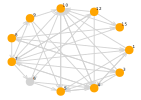

In [16]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles)
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])


#### CLuster de taille 5

In [17]:
ClusterSize = 5
dist = "BinomialAPD"
number_instance = 9
nb_scenar = 100
K = 3
nb_cycles = 10^6
;

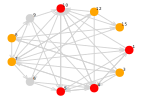

In [18]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles)
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])


#### CLuster de taille 3

In [19]:
ClusterSize = 3
dist = "BinomialAPD"
number_instance = 9
nb_scenar = 100
K = 3
nb_cycles = 10^6
;

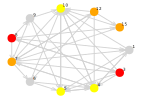

In [20]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles, [1, 1])
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])


#### CLuster de taille 2

In [21]:
ClusterSize = 2
dist = "BinomialAPD"
number_instance = 9
nb_scenar = 100
K = 3
nb_cycles = 10^6
;

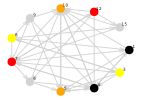

In [22]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles, [1, 1])
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])


Nous pouvons voir qualitativement que notre modélisation permet de répartir les pairs de manière logique. Les solutions tendent à créer des clusters dont la taille sature la contrainte de capacité. Ainsi, si cela est possible, notre modèle retournera des gros clusters. Cependant, lorsque l'on réduit leur taille alors les solutions restent toujours cohérentes et une bonne partie des personnes sont présentes dans un cluster. Cette première étude permet de voir que qualitativement le pré-processing la modélisation et la méthode de résolution en L fonctionne correctement. Cependant, nous disposons de méthodes quantitatives pour évaluer notre solution.

### Deuxième test sur la méthode en L : $\textbf{Qualité de la solution}$

Nous allons venir tester `LshapeClusterMethod` sur plusieurs exemples simples (pour la rapidité des calculs). Pour tester nos méthodes, nous allons comparer la solution obtenue par l'algorithme de Benders et la solution du problème déroulé *i.e.* la solution du problème où on écrit toutes les contraintes pour chaque scénario. On écrit comme un programme linéaire le problème $\mathbb{CP}$. Cette dernière méthode donne la solution théorique que l'on doit trouver. L'algorithme de Benders peut ne pas trouver la solution du problème initial, car elle utilise une relaxation linéaire (on considère les variables de recours comme continues et non plus binaires) lors de la résolution des problèmes de recours, de manière à en fournir un dual, qui sera ensuite ajouté à notre problème principal. Nous savons cependant que comme la méthode de Benders résout une relaxation linéaire la solution qu'elle fournit doit-être au moins supérieur ou égale à la solution du problème déroulé.

Pour les différentes résolutions, nous utiliserons les paramètres suivants :
- $3$ comme taille maximum de cycles
- $10$ comme taille de cluster
- $100$ scénarios
- les probabilités associées à chaque arc seront tirés selon la densité BinomialAPD.

In [23]:
df = DataFrame(
    Status = Bool[], 
    nb_it = Int[] , 
    nb_cons = Int[], 
    nb_cycles = Int[],
    obj_benders = Float64[], 
    obj_unroll = Float64[],
    z_sp = [],
    EVPI = [],
    VSS = [],
    nb_p_clus = [],
    nb_clus = [],
    nb_pers_tr = [],
    nb_cycle_tr = []
);

list_dir = readdir(join(["_cache", "data"], Base.Filesystem.path_separator));

for i in list_name[1:9]
    try
        sum_up(i, df, 2, 100, 1000, 30, 3, "BinomialAPD")
    catch
        println("error")
    end;
end;
df_moyenne = df
df_moyenne

Row,Status,nb_it,nb_cons,nb_cycles,obj_benders,obj_unroll,z_sp,EVPI,VSS,nb_p_clus,nb_clus,nb_pers_tr,nb_cycle_tr
,Bool,Int64,Int64,Int64,Float64,Float64,Any,Any,Any,Any,Any,Any,Any
1,true,2,79,2,2.24,2.24,2.082,0.0,0.0,4.0,2.0,2.082,1.041
2,true,8,419,10,2.26,2.26,2.638,0.0,0.0,8.0,4.0,2.638,1.319
3,true,2,53,2,1.06,1.06,0.988,0.512,-0.032,2.0,1.0,0.988,0.494
4,false,0,0,0,-1.0,-1.0,no feas,no feas,no feas,no feas,no feas,no feas,no feas
5,true,10,608,17,1.22,1.22,1.078,0.606,0.0,4.0,2.0,1.078,0.539
6,true,4,134,4,1.08,1.08,0.99,0.918,-0.062,2.0,1.0,0.99,0.495
7,true,4,256,6,2.14,2.14,2.122,0.226,0.0,4.0,2.0,2.122,1.061
8,true,14,934,20,2.14,2.14,2.156,0.844,0.072,4.0,2.0,2.156,1.078
9,true,9,624,19,3.46,3.46,3.284,0.718,0.0,8.0,4.0,3.284,1.642


Nous pouvons remarquer ici que l'instance `./_cache/data/MD-00001-00000004` pose un problème, cela est dû au fait que cette instance ne possède aucun cycle et n'est donc en aucun cas intéressante pour la suite. 

Dans les autres cas, nous avons exactement les mêmes valeurs entre les deux méthodes et de plus la méthode de Benders a été utilisée, on peut en effet voir que le nombre de contraintes ajoutées et le nombre d'itérations de l'algorithme de Benders sont non nulles.

On peut remarquer que les instances `./_cache/data/MD-00001-00000005` et `./_cache/data/MD-00001-00000008` donnent beaucoup plus de mal, et générent un nombre de contraintes et d'itérations beaucoup plus important que dans le cas des autres instances. Nous pouvons regarder ces instances en particulier et noter que sans surprise nous avons un nombre de cycles dans le graphe qui est beaucoup plus important, en effet beaucoup de cycle dans un graphe va venir faire augmenter considérablement la taille de notre problème dans la méthode de Benders. 

Nous pouvons voir ici une problématique de notre implémentation quand le graphe sera très dense (beaucoup d'arêtes et donc beaucoup de cycles), notre problème maître va grossir et donc va être de plus en plus compliquer à résoudre.

Comme nous pouvons le voir dans ce tableau, nous avons décidé d'évaluer pour chaque instance notre solution issue de la méthode en $L$, avec les critères $VSS$ et $EVPI$. 

- Le critère $VSS$, nous permet de voir combien on gagne par rapport au problème aux valeurs moyennes, qui est le problème déterministe dans lequel les incertitudes/variables aléatoire $\xi$ sont remplacées par leurs valeurs moyennes/espérances. Nous pouvons voir que ce critère est toujours relativement proche de $0$. En effet nous ne gagnons quasiment rien à utiliser notre méthode en $L$ comparé au problème aux valeurs moyenne. Ce résultat n'est pas très représentatif de la réalité étant donné que les graphes sont très petits et ne contiennent que très peu de cycles ici.

- Le critère $EVPI$, nous permet de voir combien on gagne par rapport au problème *wait and see*. Ce problème *wait and see* est le problème dans lequel on attend que les incertitudes se réalisent pour ensuite prendre la décision. Etant donné que dans ce problème on adapte chaque décision aux incertitudes, nous pouvons voir que nous gagnons quasiment toujours à prendre le problème *wait and see*. Une fois de plus ce critère est à remettre en perspective de nos instances de test. Ces instances sont très pauvres et ne permettent pas de se rendre vraiment compte du réel comportement des solutions.

Ces deux critères sont essentiellement ici pour vérifier un résultat théorique qui est que $VSS$ en $EVPI$ sont des quantités qui sont positives. Nous pouvons voir qu’ici cela est vérifié sauf dans certains cas particulier (si vous êtes amenés à réexecuter les cellules) pour la quantité $VSS$. Nous pouvons voir que ces écarts sont marginaux et sont essentiellement dû au fait que nous faisons un échantillonnage pour trouver la solution de notre méthode en $L$ et que le problème aux valeurs moyennes n'est pas exactement celui qui correspond au vrai problème aux valeurs moyennes. En effet la moyenne empirique d'un échantillon ne correspond pas à l'espérance de la loi de cet échantillon, d'où les écarts à la théorie que l'on peut observer.

D'une manière générale, ce tableau nous donne des résultats en accord avec la théorie des problèmes à recours, et nous permet ainsi de valider notre méthode en $L$, ainsi que son bon fonctionnement.

### Troisième test sur la méthode en L : $\textbf{Effet du nombre de cycles}$

Nous allons maintenant réaliser des tests plus avancés. Nous allons nous concentrer sur l'instance `MD-00001-00000001`. Cette instance ne possède que très peu de cycle de taille 3. Nous allons ainsi considérer cette instance et venir augmenter le nombre de cycles. Avec cette augmentation du nombre de cycles, nous allons venir suivre l'évolution du nombre d'itérations de l'algorithme de Benders et du nombre de contraintes que l'on ajoute dans l'algorithme.


Nous avons créé un dossier qui contient des fonctions pour ajouter des arcs aléatoirement, bien choisi et aussi pour ajouter aléatoirement des cycles. Nous allons utiliser la fonction `addRandomCycles` pour ajouter des cycles. Cette fonction permet d'ajouter au moins un cycle au graphe de taille préalablement choisi.

Voici par exemple notre instance 1 après le pré-processing.

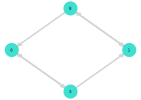

In [24]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
kep_graph, list_rem_nodes = removeUselessNodes(kep_graph, 3)
failure_rates = get_failure_rates(kep_graph, "Constant");
plot_graph(kep_graph, list_rem_nodes)

En ajoutant au moins un cycle de taille 2. On obtient le graphe suivant :

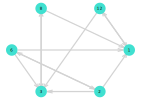

In [25]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
kep_graph = addRandomCycles(kep_graph, 1, 0.7, 1, 3)
kep_graph, list_rem_nodes = removeUselessNodes(kep_graph, 2)
failure_rates = get_failure_rates(kep_graph, "Constant");
plot_graph(kep_graph, list_rem_nodes)

En ajoutant au moins un cycle de taille 3. On obtient le graphe suivant :

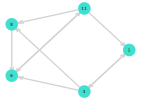

In [26]:
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
kep_graph = addRandomCycles(kep_graph, 1, 0.7, 1, 3)
kep_graph, list_rem_nodes = removeUselessNodes(kep_graph, 3)
failure_rates = get_failure_rates(kep_graph, "Constant");
plot_graph(kep_graph, list_rem_nodes)

Avec cette expérience, nous voulons voir si ces deux quantités ont tendance à évoluer de manière polynomiale ou exponentielle. À première vue, nous nous attendons à observer un comportement exponentiel.

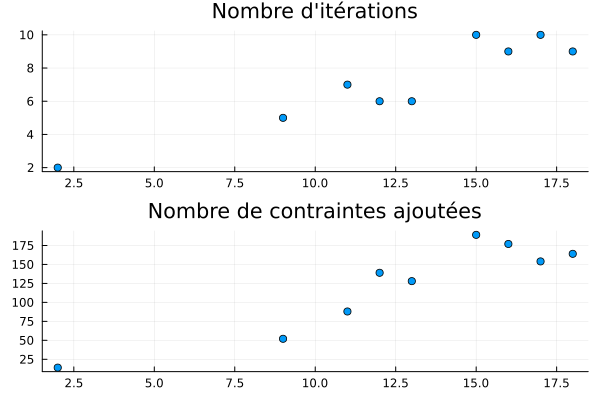

In [27]:
nb_cycles = []
nb_iterations = []
nb_added_constraints = []

# init the kep graph
kep_graph = read_kep_file("./_cache/data/MD-00001-00000001.wmd","./_cache/data/MD-00001-00000001.dat");
failure_rates = get_failure_rates(kep_graph, "Constant");

for i in 1:1:9
    data = extractCycleInformation(kep_graph, 3, "sum");
    C = data["Cycles_index"] 
    cycles = data["Cycles"]
    U = data["U"]
    ClusterSize = 10
    vertic_cycles = data["vertic_cycles"]
    nb_scenar = 100

    ksi = getScenarioClusterK(kep_graph, nb_scenar)

    res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
    append!(nb_cycles, length(cycles))
    append!(nb_iterations, res_lshape["nb_iterations"])
    append!(nb_added_constraints, res_lshape["nb_added_constraints"])

    kep_graph = addRandomCycles(kep_graph, 1, 0.7, 1, 3)
end

p1 = Plots.scatter(nb_cycles, nb_iterations, title="Nombre d'itérations")
p2 = Plots.scatter(nb_cycles, nb_added_constraints, title="Nombre de contraintes ajoutées")
Plots.plot(p1, p2, layout=(2, 1), legend=false)

On peut voir une augmentation du nombre d'itérations ainsi que du nombre de contraintes rajoutées qui est de type exponentiel. Ainsi, notre méthode de résolution va très sûrement rencontrer des problèmes lorsque nous allons traiter des instances conséquentes.

### Quatrième test sur la méthode en L : $\textbf{Effet de la distribution de probabilité}$.

L'ensemble des interprétations faites jusqu'ici ont été faites pour des distributions de probabilités qui sont uniformes. Nous allons maintenant regarder ce qu'il se passe lorsque l'on change la distribution de probabilité. Pour regarder cela, nous allons considérer l'instance `./_cache/data/MD-00001-00000009`. Cette instance possède la particularité d'avoir peu de nœuds, mais un nombre intéressant de cycles.

In [28]:
df = DataFrame(
    Status = Bool[], 
    nb_it = Int[] , 
    nb_cons = Int[], 
    nb_cycles = Int[],
    obj_benders = Float64[], 
    obj_unroll = Float64[],
    z_sp = [],
    EVPI = [],
    VSS = [],
    nb_p_clus = [],
    nb_clus = [],
    nb_pers_tr = [],
    nb_cycle_tr = []
);

for dist in DISTRIBUTIONS
    sum_up(9, df, 10, 100, 1000, 30, 3, dist)
end;

df[!, :Distribution] = DISTRIBUTIONS
df_dist_moyenne = df[:, [:Distribution, :obj_benders, :z_sp, :EVPI, :VSS]]
df_dist_moyenne

Row,Distribution,obj_benders,z_sp,EVPI,VSS
,String,Float64,Any,Any,Any
1,Constant,1.53,1.581,0.058,0.25
2,Binomial,2.94,2.883,0.003,0.0
3,BinomialUNOS,5.83,5.9115,0.0025,0.1135
4,BinomialAPD,5.71,5.5,0.012,0.254
5,NoFailure,9.0,9.0,0.0,0.0


Nous pouvons faire des observations intéressantes. Tout d'abord, nous pouvons voir qu'avec des distributions comme *BinomialUNOS* ou *BinomialAPD*, nous obtenons des valeurs objectives beaucoup plus importantes. Nous décidons ainsi de comparer plusieurs mesures statistiques pour comprendre d'où ces différences peuvent provenir.
Nous supposons que ces différences peuvent venir du fait que les distributions de probabilité donnent des probabilités plus ou moins uniformes sur l'ensemble de nos arêtes et que les différences entre les différentes probabilités peuvent donner lieu à des meilleures sélections des cycles.

Pour s'assurer de ce que l'on vient d'énoncer, nous proposons de mesurer le désordre du graphe. Nous allons proposer ici une mesure qui permet de mesurer si une distribution de probabilité nous donne une discrimination entre les cycles ou pas. Pour chaque cycle $c$ on a $p(c)$ la probabilité que le cycle $c$ se réalise. On construit le vecteur $\alpha$ tel que :
$$
\alpha_c = \frac{e^{p(c)}}{\sum_{j \in C}e^{p(j)}}
$$

Ainsi, en accord avec ce vecteur, nous pouvons calculer l'entropie de Shannon de $\alpha$ 

$$
H(\alpha) = -\frac{1}{log(|C|)}\sum_{c \in C} \alpha_c log(\alpha_c)
$$

Cette quantité comprise entre 0 et 1 nous permet de mesurer les discriminations entre nos cycles. Si l'entropie vaut 1 alors toutes les probabilités associées aux cycles sont égales, si l'entropie vaut 0 alors au contraire 1 cycle sera différents et tous les autres auront des valeurs faibles.

Une autre mesure du désordre, plus classique en statistique est la variance (ou écart type).
En effet, nous pouvons simplement venir mesurer $\sigma = \sqrt{\mathbb{V}(p(c))}$

Enfin dans la même philosophie que la variance, nous pouvons regarder l'étendue de nos probabilités sur nos différents cycles en regardant $max(p)$ et $min(p)$

Dans la cellule suivante, nous regardons l'ensemble de ces mesures.

In [29]:
df = DataFrame(
    Distribution = String[],
    H = Float64[],
    σ = Float64[],
    max = Float64[],
    min = Float64[]
)

for dist in DISTRIBUTIONS
    i = 9
    try
        kep_graph = read_kep_file("./_cache/data/MD-00001-0000000$i.wmd","./_cache/data/MD-00001-0000000$i.dat");
        failure_rates = get_failure_rates(kep_graph, dist);
        data = extractCycleInformation(kep_graph, 3, "sum")
        p = 1 .- data["P"]
        σ = Statistics.std(p)
        α = exp.(p) / sum(exp.(p))
        h = -1/log(length(data["Cycles_index"])) * sum(α .* log.(α))
        push!(df, [dist h σ maximum(p) minimum(p)])
    catch
        # do nothing
        println("error")
    end
end;

df

Row,Distribution,H,σ,max,min
,String,Float64,Float64,Float64,Float64
1,Constant,0.999842,0.0312225,0.09,0.027
2,Binomial,0.999786,0.0352502,0.144315,3.60743e-5
3,BinomialUNOS,0.986136,0.32465,0.81,0.081
4,BinomialAPD,0.998106,0.108539,0.5184,0.217728
5,NoFailure,1.0,0.0,1.0,1.0


Nous pouvons voir que les trois dernières distributions se détachent réellement des autres par leur étendue, en effet elles attribuent des probabilités plus élevées à nos cycles. Ainsi, nous avons plus de cycles qui fonctionnent donc nous en sélections plus d'où l'augmentation de la fonction objectif.

Le cas de la distribution *NoFailure*, est un peu particulier, il s'agit du cas, où aucun cycle ne peut échouer. Dans ce cas, notre problème stochastique se ramène au problème déterministe.
Nous pouvons vérifier cela en regardant l'objectif du problème déterministe dans le cas où les distributions sont constantes.

In [30]:
# comparons le cas no failure avec la version déterministe
kep_graph = read_kep_file("./_cache/data/MD-00001-00000009.wmd","./_cache/data/MD-00001-00000009.dat");
failure_rates = get_failure_rates(kep_graph, "NoFailure");
data = extractCycleInformation(kep_graph, 3, "sum");

# the model
res = completRecourseProblem(data["Cycles_index"], data["vertic_cycles"], data["U"], 1 .-data["P"]);
model = res["model"]

temp = @elapsed optimize!(model)
print("objectif du problème déterministe : "*string(objective_value(model)))
solution = value.(model[:x])
;

objectif du problème déterministe : 9.0

Nous obtenons effectivement la même valeur ce qui vient confirmer de nouveau le bon fonctionnement de notre fonction.


### Proposition d'une heuristique pour les grandes instances

Il se trouve que ce qui pose problème pour notre problème, est le nombre de cycles dans le graphe. Il nous faut pour cela trouver une stratégie pour essayer de faire une énumération réduite des cycles.

Tout d'abord à chaque cycle $c$ appartenant à notre ensemble de cycles, nous lui attribuons une note $e_c$. Cette note sera simplement calculée de la façon suivante :

$$
e_c = u_c \times p(c)
$$

Avec :

- $u_c$ : l'utilité du cycle $c$
- $p(c)$ : la probabilité que le cycle $c$ se réalise.

Nous pouvons organiser les cycles dans notre graphe par ordre décroissant de leurs notes. Notre manière d'approcher le problème sera ainsi la suivante :

1. nous sélectionner initialement les $J$ cycles avec les meilleures notes.
2. nous résolvons le problème pour ces cycles.
3. nous ajoutons le prochain cycle à notre ensemble de cycle, puis nous retournons à l'étape deux.

Si entre deux ajouts de cycles la valeur objective n'a pas subit une variation significative alors nous stoppons l'algorithme. Cette heuristique est inspirée des méthodes de générations de colonnes, qui à chaque itération vont venir ajouter des cycles dans notre problème.


Dans un premier temps, nous allons considérer que quelques itérations de notre heuristique pour comprendre comment cette dernière pourrait fonctionner.

Nous regardons l'instance $31$, cette instance a la particularité d'avoir beaucoup de cycles de longueur $3$ ainsi nous décidons dans la cellule suivante de ne regarder la résolution du problème que pour 15 cycles.

In [45]:
K = 3
nb_scenar = 20
ClusterSize = 10


kep_graph = read_kep_file("./_cache/data/MD-00001-00000031.wmd","./_cache/data/MD-00001-00000031.dat");
kep_graph, temp = removeUselessNodes(kep_graph, K)
failure_rates = get_failure_rates(kep_graph, "BinomialAPD");
data = extractCycleInformation(kep_graph, K, "sum");

rank_index = rank_index_cycle(data)
cycles = data["Cycles"]
U = data["U"]

# create scenarios
ξ = getScenarioClusterK(kep_graph, nb_scenar)
;

In [46]:
nb_cycles_to_keep = 15

C = data["Cycles_index"][rank_index][1:nb_cycles_to_keep]
vertic_cycles = transform_vertic_cycle(data["vertic_cycles"], C)
res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ξ, 50, 1e-3, true)
;
println("valeur objectif : "*string(res_lshape["objective_value"]))

Start of the L-shape method for the cluster problem
Iteration (10) >> objective value : 3.7500000000000004
Iteration (20) >> objective value : 3.45
The stopping criterion is reached
The objective value : 3.300000000000021
valeur objectif : 3.300000000000021


Nous allons maintenant rajouter $5$ cycles à notre problème et regarder l'évolution de la solution.

In [47]:
nb_cycles_to_keep = 20

C = data["Cycles_index"][rank_index][1:nb_cycles_to_keep]
vertic_cycles = transform_vertic_cycle(data["vertic_cycles"], C)
res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ξ, 50, 1e-3, true)
;
println("valeur objectif : "*string(res_lshape["objective_value"]))

Start of the L-shape method for the cluster problem
Iteration (10) >> objective value : 4.875000000000004
Iteration (20) >> objective value : 4.3500000000000005
The stopping criterion is reached
The objective value : 4.275000000000001
valeur objectif : 4.275000000000001


Nous rajoutons maintenant $2$ cycles à notre problème.

In [48]:
nb_cycles_to_keep = 22

C = data["Cycles_index"][rank_index][1:nb_cycles_to_keep]
vertic_cycles = transform_vertic_cycle(data["vertic_cycles"], C)
res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ξ, 70, 1e-3, true)
;
println("valeur objectif : "*string(res_lshape["objective_value"]))

Start of the L-shape method for the cluster problem
Iteration (10) >> objective value : 4.950000000000001
Iteration (20) >> objective value : 4.500000000000002
The stopping criterion is reached
The objective value : 4.425000000000001
valeur objectif : 4.425000000000001


Nous continuons ainsi dessuite en ajoutant au fur et à mesure des cycles. Jusqu'à ce que la valeur objective se stabilise. Ici nous pouvons voir que la valeur objectif s'est stabilisée, ainsi nous pouvons arréter les itérations.

Cette méthode est ici très peu efficace, car à chaque itération, nous rajoutons un nombre arbitraire de cycles et surtout, nous résolvons le problème *from scratch*.
Afin d'améliorer grandement cette méthode, il nous faudrait modifier le notre méthode en $l$, pour pouvoir initialiser à chaque fois notre méthode avec la valeur que l'on obtient à l'itération d'avant. Il faut ensuite se donner un critère d'arrêt pour pouvoir stopper la méthode quand l'objectif reste relativement stable.

### Modelisation averse au risque

L'agence qui nous a contacté initialement nous recontacte et nous dit que notre solution ne sert à rien. Dans certains, on sauve beaucoup de patients dans d'autres cas, on ne sauve personne. On nous dit alors que notre solution ne sert à rien que c'est du hasard et qu'il n'y a pas besoin de mathématiciens pour faire des sélections au hasard. On essaye de leur expliquer que ce n'est pas du hasard et qu'en moyenne notre solution est optimale. En moyenne ? Il faut que la solution marche dans quasiment tous les cas pour être valide.

On nous renvoie ainsi un cahier des charges, on nous renvoie un cahier des charges et on nous ordonne de produire une solution qui dans $\alpha \%$ des cas permet de sauver un nombre minimum de patients. Nous décidons ainsi d'introduire la notion de *Conditional Value at Risk* ou encore $CVaR$ pour résoudre le problème. Cette méthode permet de produire une solution qui assure avec un certain niveau de risque, de ne pas descendre en dessous d'un certain niveau.

Tout ceci se formule mathématiquement de la manière suivante :


$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{1-\alpha}\mathbb{E}_{\omega}\left[\left(\underset{y}{\min}\left( - \sum_{c \in C_K}y_c(\omega) w_c\right) - t\right)+\right]\\
         s.c &\quad x_{i,j} = x_{j,i}\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k} \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
	\end{aligned}\right.
\end{equation}
$$

Cette modélisation averse au risque peut se linéariser de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \pi(\omega) \geq \left(\underset{y}{\min}\left( - \sum_{c\in C_K}y_c(\omega) w_c\right) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad y_c(\omega) \leq x_{i,j}\xi_{i,j}(\omega) \quad \forall c \in C_k, ~\forall (i,j) \in c,~ \forall \omega \in \Omega \\
         &\quad \sum_{c \in C_K(i)} y_c(\omega) \leq 1 \quad \forall i \in V,\quad\forall \omega \in \Omega\\
         
	\end{aligned}\right.
\end{equation}
$$

On utilise une équation qui est bien connue est qui est que : $\min -f(x) = - \max f(x)$. Ainsi, nous pouvons réécrire ce problème de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-v_{\omega}(x) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

Or, nous avons exprimé la valeur du problème $v_{\omega}(x)$, dans la section précédente. Ainsi, nous pouvons réécrire ce problème de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-\underset{\theta(\omega)}{\max}~~\theta(\omega) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P), \forall \omega \in \Omega\\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

Nous pouvons finalement réecrire ce problème de la façon suivante :

$$
\begin{equation}
	\mathbb{RACP}:= \left\{\begin{aligned}
        \underset{x,t}{\min} &\quad t + \frac{1}{(1-\alpha)\times |\Omega|}\sum_{\omega \in \Omega} \pi(\omega)\\
         s.c &\quad x_{i,j} = x_{j,i},\quad \forall (i,j) \in V\times V\\
         &\quad x_{i,j} + x_{j,k} -1 \leq x_{i,k}, \quad \forall (i,j,k) \in V\times V\times V\\
         &\quad \sum_{j \in V} x_{i,j} \leq U, \quad \forall i \in V \\
         &\quad \pi(\omega) \geq \left(-\theta(\omega) - t\right),\quad \forall \omega \in \Omega \\
         &\quad \theta(\omega) \leq \sum_{c \in C_{K}}\sum_{(i,j) \in c} \lambda_{(i,j)}^c x_{i,j}\xi_{i,j}(\omega) + \sum_{i \in V}\mu_i + \sum_{c \in C_K} \Delta_c \quad\forall~\lambda, \mu, \Delta ~\in~\Lambda(P), \forall \omega \in \Omega\\
         &\quad \pi(\omega) \geq 0,\quad \forall \omega \in \Omega \\
	\end{aligned}\right.
\end{equation}
$$

En effet, le maximum peut être retiré, il nous faut simplement un point réalisable.

Le gros avantage de cette méthode est qu'elle nous permet pour un moindre coût d'implémentation, d'avoir une méthode concrète. 



Premier test : $\textbf{Comparaison qualitative entre la méthode en moyenne et celle averse au risque}$

In [36]:
ClusterSize = 2
dist = "BinomialAPD"
number_instance = 9
nb_scenar = 100
K = 3
nb_cycles = 10^6
;

Nous résolvons dans un premier temps le problème en moyenne.

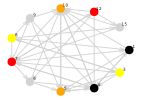

In [37]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles, [1, 1])
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])

Ensuite, nous résolvons avec une modalisation averse au risque. Comme nous pouvions nous y attendre, la méthode averse au risque sélectionne moins de personnes lors de l'affectation aux clusters.

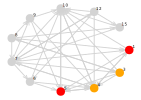

In [38]:
data = read_and_preprocess(number_instance, K, dist, nb_cycles, [1, 1])
kep_graph = data["kep_graph"]

C = data["Cycles_index"]
cycles = data["Cycles"]
U = data["U"]
vertic_cycles = data["vertic_cycles"]

# create scenarios
ksi = getScenarioClusterK(kep_graph, nb_scenar)

# solve problem
res_mean = masterClusterProblem(kep_graph, ClusterSize, C, cycles, U, vertic_cycles)
optimize!(res_mean["model"])

res_lshape = LshapeClusterMethod(kep_graph, ClusterSize, C, cycles, U, vertic_cycles, ksi, 50, 1e-3, false, true, .95)
clusterUsefull = getClusterUsefull(getCluster(kep_graph, res_lshape["first_level_var"]))
plotSolutionCluster(kep_graph, clusterUsefull, data["list_rm_cycle"])


Deuxième test : $\textbf{Comparaison quantitive entre la méthode en moyenne et averse au risque}$

In [39]:
df = DataFrame(
    Status = Bool[], 
    nb_it = Int[] , 
    nb_cons = Int[], 
    nb_cycles = Int[],
    obj_benders = Float64[], 
    obj_unroll = [],
    z_cvar = [],
    EVPI = [],
    VSS = [],
    nb_pers_clus = [],
    nb_clus = [],
    nb_pers_tr = [],
    nb_cycle_tr = []
);

list_dir = readdir(join(["_cache", "data"], Base.Filesystem.path_separator));

for i in list_name[1:9]
    try
        sum_up(i, df, 2, 200, 1000, 30, 3, "BinomialAPD", true, 0.95)
    catch
        println("error")
    end;
end;
df_cvar_95 = df[:, [:Status, :nb_it, :nb_cons, :nb_cycles, :z_cvar, :nb_pers_clus, :nb_clus, :nb_pers_tr, :nb_cycle_tr]];

error


In [40]:
df_moyenne[:, [:Status, :nb_it, :nb_cons, :nb_cycles, :z_sp, :nb_p_clus, :nb_clus, :nb_pers_tr, :nb_cycle_tr]]

Row,Status,nb_it,nb_cons,nb_cycles,z_sp,nb_p_clus,nb_clus,nb_pers_tr,nb_cycle_tr
,Bool,Int64,Int64,Int64,Any,Any,Any,Any,Any
1,true,2,79,2,2.082,4.0,2.0,2.082,1.041
2,true,8,419,10,2.638,8.0,4.0,2.638,1.319
3,true,2,53,2,0.988,2.0,1.0,0.988,0.494
4,false,0,0,0,no feas,no feas,no feas,no feas,no feas
5,true,10,608,17,1.078,4.0,2.0,1.078,0.539
6,true,4,134,4,0.99,2.0,1.0,0.99,0.495
7,true,4,256,6,2.122,4.0,2.0,2.122,1.061
8,true,14,934,20,2.156,4.0,2.0,2.156,1.078
9,true,9,624,19,3.284,8.0,4.0,3.284,1.642


In [41]:
df_cvar_95

Row,Status,nb_it,nb_cons,nb_cycles,z_cvar,nb_pers_clus,nb_clus,nb_pers_tr,nb_cycle_tr
,Bool,Int64,Int64,Int64,Any,Any,Any,Any,Any
1,true,4,199,2,empty,empty,empty,empty,empty
2,true,2,198,10,1.622,4.0,2.0,1.622,0.811
3,true,2,124,2,empty,empty,empty,empty,empty
4,false,0,0,0,no feas,no feas,no feas,no feas,no feas
5,true,1,0,17,0.0,4.0,2.0,0.0,0.0
6,true,2,100,6,0.0,2.0,1.0,0.0,0.0
7,true,3,389,20,0.0,4.0,2.0,0.0,0.0
8,true,2,200,19,1.072,2.0,1.0,1.072,0.536


Troisème test : $\textbf{Etude du niveau de risque}~\alpha$

In [42]:
df = DataFrame(
    Status = Bool[], 
    nb_it = Int[] , 
    nb_cons = Int[], 
    nb_cycles = Int[],
    obj_benders = Float64[], 
    obj_unroll = [],
    z_cvar = [],
    EVPI = [],
    VSS = [],
    nb_pers_clus = [],
    nb_clus = [],
    nb_pers_tr = [],
    nb_cycle_tr = []
);

for alpha in [0.5, 0.7, 0.9, 0.95, 0.99]
    try
        sum_up(2, df, 2, 200, 1000, 30, 3, "BinomialAPD", true, alpha)
    catch
        print("solution not found")
    end
end
df[:, [:Status, :nb_it, :nb_cons, :nb_cycles, :z_cvar, :nb_pers_clus, :nb_clus, :nb_pers_tr, :nb_cycle_tr]]

Row,Status,nb_it,nb_cons,nb_cycles,z_cvar,nb_pers_clus,nb_clus,nb_pers_tr,nb_cycle_tr
,Bool,Int64,Int64,Int64,Any,Any,Any,Any,Any
1,true,4,503,10,0.996,6.0,3.0,0.996,0.498
2,true,4,424,10,2.052,6.0,3.0,2.052,1.026
3,true,3,263,10,1.022,4.0,2.0,1.022,0.511
4,true,2,200,10,1.042,6.0,3.0,1.042,0.521
5,true,2,200,10,0.61,4.0,2.0,0.61,0.305


En augmentant $\alpha$, plus on diminue le risque et moins on selectionne de cycles.

Quatrième test : $\textbf{Etude de la distribution}$

Voici les résultats que l'on avait en résolvant le problème en moyenne avec recours.

In [43]:
df_dist_moyenne[:, [:Distribution, :obj_benders, :z_sp, :EVPI]]

Row,Distribution,obj_benders,z_sp,EVPI
,String,Float64,Any,Any
1,Constant,1.53,1.581,0.058
2,Binomial,2.94,2.883,0.003
3,BinomialUNOS,5.83,5.9115,0.0025
4,BinomialAPD,5.71,5.5,0.012
5,NoFailure,9.0,9.0,0.0


On va comparer les résultats de la distribution pour le problème avec recours et la modélisation averse au risque.

In [44]:
df = DataFrame(
    Status = Bool[], 
    nb_it = Int[] , 
    nb_cons = Int[], 
    nb_cycles = Int[],
    obj_benders = Float64[], 
    obj_unroll = [],
    z_sp = [],
    EVPI = [],
    VSS = [],
    nb_p_clus = [],
    nb_clus = [],
    nb_pers_tr = [],
    nb_cycle_tr = []
);

for dist in DISTRIBUTIONS
    try
        sum_up(9, df, 10, 100, 1000, 30, 3, dist, true, 0.95)
    catch
        print("solution not found")
    end
end;

df[!, :Distribution] = DISTRIBUTIONS
df[:, [:Distribution, :obj_benders, :z_sp, :EVPI]]

Row,Distribution,obj_benders,z_sp,EVPI
,String,Float64,Any,Any
1,Constant,0.0,0.18,1.439
2,Binomial,0.0,2.66,0.159
3,BinomialUNOS,0.0,1.63,4.273
4,BinomialAPD,0.0,2.076,3.4775
5,NoFailure,-2.0,2.0,7.0


On observe les mêmes résultats et interprétations que pour le cas où on maximise la valeur moyenne avec recours.

## Conclusion

### Critique sur notre modélisation

Nous avons proposé une modélisation par clusters. Celle-ci constant à regrouper des personnes sélectionnées préalablement pour réaliser tous les tests croisés possible dans celui-ci. Une fois que les résultats de ces tests sont disponibles, notre modèle propose de réaliser les transplantations qui maximisent l'utilité de cycle de patients/doneurs.

C'est une modélisation que nous avons trouvé pertinente. En revanche, certains points peuvent être discutés. En effet, lorsque l'on sélectionne un cluster alors on doit réaliser tous les tests. Cela signifie que lorsque la taille des clusters augmentent alors cela demandera beaucoup de travail pour le personnel médical. Il faut également que toutes les personnes d'un même cluster se rendent dans un même hôpital. Dans notre modélisation, nous ne prenons pas en compte la proximité entre les personnes. Cela serait légitime de vouloir regrouper des personnes proches géographiquement. De plus, une fois que nous avons fait les clusters, il faut résoudre un problème d'affectation pour affecter les clusters à des hôpitaux en minimisant par exemple la distance à parcours au sein d'un cluster par les paires. 

### Travail réalisé

Ce projet nous a permis de résoudre un projet d'optimisation sous incertitudes dans son entièreté. Dans un premier temps, nous avons commencé par faire une étude d'articles pour définir la modélisation qui nous semblait la plus pertinente et le problème que nous souhaitons étudier puis résoudre. Nous avons ensuite dû le modéliser mathématiquement puis développer nos modèles et démonstration justifiant théoriquement nos expériences. Ensuite, nous avons implémenté de nombreuses méthodes et fonctions qui sont disponibles https://github.com/lolofo/KidneyExchangeProgram. Nous avons pu nous rendre compte que résoudre le problème du $\textbf{Kidney exchange}$ était très compliqué quand la taille des instances augmentes. En effet, le nombre de contraintes augmente de manière exponentielle avec celles-ci. Nous avons proposé des méthodes de pré-processing ainsi que des tests pour limiter la taille des instances et le nombre de contraintes inutiles. Malgré cela, résoudre les gros instances de manière exactes s'est montré être compliqué. Nous avons donc proposé une heuristique pour que notre modélisation puisse passer à l'échelle. Enfin, nous avons évalué qualitativement et quantitativement nos résultats.

### Perspectives

Dans une perspective de poursuite de ce projet, nous pensons qu'il serait pertinent de développé une heuristique pour que notre modélisation passe à l'échelle. Nous avons pu faire plusieurs étapes pour re-factoriser notre code, mais nous pensons qu'il reste des efforts à faire dans cette direction.

## Bibliographie

    - [1] Péter Biró and al. (2019), European Journal of Operational Research
    - [2] Filipe Alvelos and al. (2017), Maximizing the expected number of transplants in kidney exchange programs with branch-and-price
    - [3] Miguel Constantino and al. (2013), New insights on integer-programming models for the kidney exchange problem